# Noise ceiling simulation

In this notebook we will simulate some data to highlight some components of the normalized correlation coefficient and the effect of a low number of repeats.

We're going to simulate the following scenario. We hypothesize a true stimulus-dependent response $\mu$ in a single voxel and a model that generates a prediction $\hat{y}$ such that $r(\mu, \hat{y}) = 0.7$.

We then simulate a measured response with a fixed level of explainable variance, that is $y_i[t] = \mu_i[t] + \epsilon_i[t]$ such that $r(y_i, \mu) = \sqrt{\mathrm{EV}}$, with $i = 1, ..., M$ being a simulated brain response to the $i$-th stimulus repetition. 

The average across stimulus repetition is defined as $\tilde{y} = \frac{1}{M}\sum_{i=1}^M y_i$. We define the difference between each repetitions and the average across repetitions as $e_i = y_i - \tilde{y}$.

We vary $\mathrm{EV} \in [0, 1]$ and visualize the following quantities

$$
\mathrm{EV} = 1 - \frac{M}{M-1}\sum_{i=1}^M\mathrm{Var}_t(e_i)\\
r_\mathrm{max} = \sqrt{\frac{\mathrm{EV}}{\mathrm{Var}_t(\tilde{y})}}\\
r_\mathrm{abs} = r(\hat{y}, \tilde{y}) \\
r_\mathrm{norm} = \frac{r_\mathrm{abs}}{r_\mathrm{norm}}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from tikreg.utils import explainable_variance, columnwise_correlation

import matplotlib.pyplot as plt
%matplotlib inline

from utils import make_correlated_signal, scatter
import matplotlib as mpl

In [3]:
# true model performance (in r)
true_model_score = 0.7

# simulated ev levels (in R2)
simulated_ev = np.linspace(0, 1, 100)

from collections import defaultdict

rng = np.random.RandomState(23423)

n_voxels = 10  # a single voxel for each EV level for now
n_repeats = 10
n_samples = 300

# create a "true" noiseless response for every channel
Ytrue = rng.randn(n_samples, n_voxels)
# Model prediction w/ desired model accuracy
Ypred = make_correlated_signal(Ytrue, rho=true_model_score, rng=rng)

# Make a single dataset with n_voxels * n_simulated_ev Voxels and n_repeats
Yrep = []
for desired_ev in simulated_ev:
    Yrep.append(np.stack([
        make_correlated_signal(Ytrue, rho=np.sqrt(desired_ev), rng=rng) 
        for _ in range(n_repeats)
    ]))
Yrep = np.concatenate(Yrep, -1)

In [4]:
def compute_values_to_plot(Yrep, Ypred):
    values_to_plot = dict()
    Yrep = zscore(Yrep, 1)
    Yavg = Yrep.mean(0)
    # EV
    ev = explainable_variance(Yrep, dozscore=False)
    mask_ev = (ev < 0) | np.isnan(ev)
    ev[mask_ev] = 0
    values_to_plot['EV'] = ev
    # r_max
    rmax = np.sqrt(ev/Yavg.var(0))
    rmax[mask_ev] = np.nan
    values_to_plot['r_max'] = rmax
    # r_abs
    values_to_plot['r_abs'] = columnwise_correlation(Yavg, Ypred)
    # r_norm
    values_to_plot['r_norm'] = values_to_plot['r_abs'] / values_to_plot['r_max']
    return values_to_plot

def plot_all(values_to_plot, order, ylabels, true_model_score, simulated_ev):
    from matplotlib.colors import Normalize
    cmap = plt.get_cmap('plasma')
    norm = Normalize(0, 1)

    fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True, constrained_layout=True)

    lims = [-0.05, 1.05]
    color = [cmap(norm(sev)) for sev in simulated_ev]
    
    for ax, o, ylabel in zip(axs.flat, order, ylabels):
        vals = values_to_plot[o]
        ax.scatter(simulated_ev, vals, alpha=0.5, color=color, marker='.')
        ax.set_ylabel(ylabel, fontsize=18)
        # ax.grid(axis='x')
        ax.axis('square')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        # ax.set_xticks(simulated_ev)

        if o in ['EV']:
            ax.plot(lims, lims, color='lightgray', linestyle='dashed', zorder=0)
        if 'abs' in o:
            ax.axhline(true_model_score, color='k', linestyle='dashed', zorder=0)
            ax.set_xlabel(r'Simulated $\mathrm{EV}$', fontsize=16)
            # ax.text(0.05, 0.71, r'$R^2\,(\hat{Y}, \mu) = 0.7$', ha='left', va='bottom', fontsize=14)
        if 'norm' in o:
            ax.axhline(true_model_score, color='k', linestyle='dashed', zorder=0)
            ax.set_xlabel(r'Simulated $\mathrm{EV}$', fontsize=16)
        # if 'max' in o:
        #    ax.axhline(true_model_score, color='k', linestyle='dashed', zorder=0)

        # XXX: add text with r(\hat{Y}, \mu) = 0.7 next to dashed line
        for tick in ax.get_xticklabels(which='major'):
            tick.set_fontsize(12)
        for tick in ax.get_yticklabels(which='major'):
            tick.set_fontsize(12)
            # tick.set_fontname("Roboto Condensed")  
    
    # add colorbar
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axins = inset_axes(fig.axes[-1],
                       width="3%",  # width = 5% of parent_bbox width
                       height="50%",  # height : 50%
                       loc='center left',
                       bbox_to_anchor=(1.05, .6, 1, 1),
                       bbox_transform=fig.axes[-1].transAxes,
                       borderpad=0,
                       )

    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                      cax=axins, orientation='vertical', ticks=[0, 0.5, 1])
    cb.set_label('Simulated EV', fontsize=14)
    return fig

In [5]:
# Compute values to plot for a varying number of repetitions
all_values_to_plot = {
    i: compute_values_to_plot(
        Yrep[:i], 
        np.tile(Ypred, len(simulated_ev))) 
    for i in range(2, 11)
}

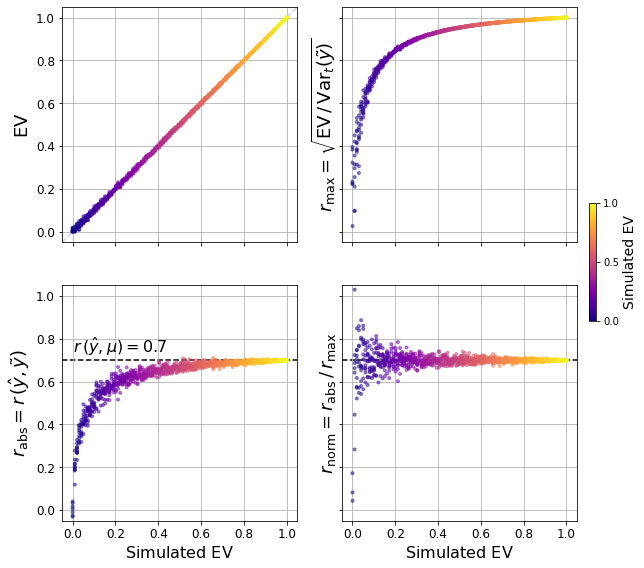

In [13]:
values_to_plot = all_values_to_plot[10]  # 10 repeats
order = ['EV', 'r_max', 'r_abs', 'r_norm']
ylabels = [
    r'$\mathrm{EV}$',
    r'$r_\mathrm{max} = \sqrt{\mathrm{EV}\,/\,\mathrm{Var}_t(\tilde{y})}}$',
    r'$r_\mathrm{abs} = r\,(\hat{y}, \tilde{y})$',
    r'$r_\mathrm{norm} = r_\mathrm{abs}\,/\,r_\mathrm{max}$'
]
fig = plot_all(values_to_plot, order, ylabels, .7, np.repeat(simulated_ev, n_voxels));
ax = fig.axes[2]
_ = ax.text(0, 0.71, r'$r\,(\hat{y}, \mu) = 0.7$', ha='left', va='bottom', fontsize=16)
#plt.tight_layout()
for ax in fig.axes:
    ax.grid()
    ax.set_axisbelow(True)

In [14]:
def plot_comparison_repeats(all_values_to_plot, x_rep=2, y_rep=10, simulated_ev=simulated_ev):
    from matplotlib.colors import Normalize
    cmap = plt.get_cmap('plasma')
    norm = Normalize(0, 1)

    color = [cmap(norm(sev)) for sev in np.repeat(simulated_ev, n_voxels)]

    fig, axs = plt.subplots(1, 3, figsize=(12, 4.5), constrained_layout=True)

    x_values = all_values_to_plot[x_rep]  # 2 repeats
    y_values = all_values_to_plot[y_rep]  # 10 repeats
    common_kwargs = dict(
        lims=[-0.05, 1.05],
        color=color, 
        mask_nans=False, 
        alpha=0.5
    )

    ax = scatter(x_values['r_abs'], y_values['r_abs'], ax=axs[0], **common_kwargs)
    ax.set_title('$r_\mathrm{abs}$', fontsize=18)
    ax.set_xlabel(f'{x_rep} repeats', fontsize=16)
    ax.set_ylabel(f'{y_rep} repeats', fontsize=16)
    ax.axvline(0.7, linestyle='dashed', color='gray', zorder=0)
    ax.axhline(0.7, linestyle='dashed', color='gray', zorder=0)

    ax = scatter(x_values['r_max'], y_values['r_max'], ax=axs[1], **common_kwargs)
    ax.set_title('$r_\mathrm{max}$', fontsize=18)
    ax.set_xlabel(f'{x_rep} repeats', fontsize=16)

    ax = scatter(x_values['r_norm'], y_values['r_norm'], ax=axs[2], **common_kwargs)
    ax.set_title('$r_\mathrm{norm}$', fontsize=18)
    ax.set_xlabel(f'{x_rep} repeats', fontsize=16)
    ax.axvline(0.7, linestyle='dashed', color='gray', zorder=0)
    ax.axhline(0.7, linestyle='dashed', color='gray', zorder=0)

    for ax in axs:
        for tick in ax.get_xticklabels(which='major'):
            tick.set_fontsize(12)
        for tick in ax.get_yticklabels(which='major'):
            tick.set_fontsize(12)
            # tick.set_fontname("Roboto Condensed")     
            
    # add colorbar
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axins = inset_axes(fig.axes[-1],
                       width="3%",  # width = 5% of parent_bbox width
                       height="100%",  # height : 50%
                       loc='center left',
                       bbox_to_anchor=(1.05, 0, 1, 1),
                       bbox_transform=fig.axes[-1].transAxes,
                       borderpad=0,
                       )

    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                      cax=axins, orientation='vertical', ticks=[0, 0.5, 1])
    cb.set_label('Simulated EV', fontsize=14)
    return fig

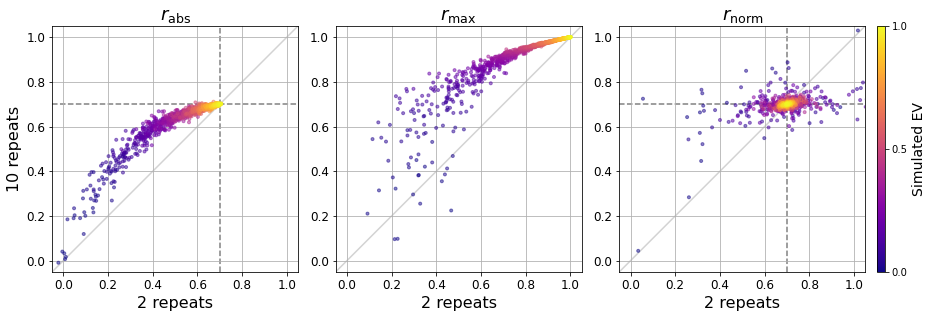

In [15]:
plot_comparison_repeats(all_values_to_plot, x_rep=2, y_rep=10);

### Make videos for both plots

In [18]:
import os
FIG_DIR = os.path.abspath('../figures/noise-ceiling-simulation') 
os.makedirs(FIG_DIR, exist_ok=True)

template_fn = os.path.join(FIG_DIR, 
                           'normalized-correlation-components-{i:02d}.png')

In [19]:
import subprocess
def make_video(template, outfn, fps=2):
    cmd = f'ffmpeg -y -framerate {fps} -i {template} ' \
          f'-vf pad=ceil(iw/2)*2:ceil(ih/2)*2 -pix_fmt yuv420p {outfn}'
    if subprocess.check_call(cmd.split()) == 0:
        return outfn
    else:
        raise OSError("FFMPEG failed")

In [20]:
order = ['EV', 'r_max', 'r_abs', 'r_norm']
ylabels = [
    r'$\mathrm{EV}$',
    r'$r_\mathrm{max} = \sqrt{\mathrm{EV}\,/\,\mathrm{Var}_t(\tilde{y})}}$',
    r'$r_\mathrm{abs} = r\,(\hat{y}, \tilde{y})$',
    r'$r_\mathrm{norm} = r_\mathrm{abs}\,/\,r_\mathrm{max}$'
]

for i, (n_rep, values_to_plot) in enumerate(all_values_to_plot.items()):
    fig = plot_all(values_to_plot, order, ylabels, .7, np.repeat(simulated_ev, n_voxels));
    ax = fig.axes[2]
    _ = ax.text(0, 0.71, r'$r\,(\hat{y}, \mu) = 0.7$', ha='left', va='bottom', fontsize=16)
    for ax in fig.axes:
        ax.grid()
        ax.set_axisbelow(True)
    fig.suptitle(f'{n_rep:2d} repeats', fontsize=18)
    fig.savefig(template_fn.format(i=i), dpi=300, bbox_inches='tight')
    plt.close()

In [21]:
make_video(template_fn.replace('{i:02d}', '%02d'), 
           os.path.join(FIG_DIR, 'normalized-correlation-components.mp4'))

'/home/jlg/mvdoc/gbox/experiments/vm-review/figures/noise-ceiling-simulation/normalized-correlation-components.mp4'

In [22]:
from IPython.display import Video

In [23]:
Video(f'{FIG_DIR}/normalized-correlation-components.mp4', width=600)

In [24]:
template_fn = os.path.join(FIG_DIR,  
                           'normalized-correlation-compare-repeats-{i:02d}.png')

for i, x_rep in enumerate(range(2, 10)):
    fig = plot_comparison_repeats(all_values_to_plot, x_rep=x_rep, y_rep=10)
    fig.savefig(template_fn.format(i=i), dpi=300, bbox_inches='tight')
    plt.close()    
    
outfn = template_fn.replace('-{i:02d}.png', '.mp4')

make_video(template_fn.replace('{i:02d}', '%02d'), outfn)
print(outfn)

/home/jlg/mvdoc/gbox/experiments/vm-review/figures/noise-ceiling-simulation/normalized-correlation-compare-repeats.mp4


In [25]:
Video(f'{FIG_DIR}/normalized-correlation-compare-repeats.mp4', width=800)